In [104]:
library(Seurat)
library(dplyr)
library(ggplot2)
library(patchwork)
library(tibble)
library(qs)
library(ggplot2)
library(ggridges)
library(tidyr)
library(RColorBrewer)
library(readxl)
library(stringr)
library(ggpubr) 
library(viridis)
library(reshape)
library(forestploter)
library(grid)

seed <- 123
set.seed(seed)
options(dplyr.summarise.inform = FALSE)
setwd("~/integration_project/step_14/11march_final/")

In [105]:
exl_file <- read_excel("/home/a.garg/integration_project/step_14/11march_final/all_pval_data.xlsx", sheet = "Sheet1", .name_repair = "minimal")

In [106]:
exl_file

Cell_state,Ab-Level 0,Ab-Others,Ab-pval,Layer,Reference
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
Homeostatic,0.22262774,0.25095440,1.06e-02,Layer II-VI,All
Activated,0.28905109,0.23654814,2.60e-04,Layer II-VI,All
Homeostatic,0.15693904,0.23961223,3.54e-03,Layer II-III,All
Activated,0.35538262,0.27175882,6.95e-03,Layer II-III,All
Homeostatic,0.30717863,0.27100419,5.33e-01,Layer IV-VI,All
Activated,0.20367279,0.20908331,7.01e-01,Layer IV-VI,All
Homeostatic,0.18905109,0.27863505,1.02e-08,Layer II-VI,Xenografted-mic
Activated,0.31970803,0.20925215,5.83e-11,Layer II-VI,Xenografted-mic
Homeostatic,0.03112840,0.08989902,1.62e-04,Layer II-III,Xenografted-mic


Homeostatic Ab level 0

In [107]:
data <- exl_file[exl_file$Cell_state == "Homeostatic",]
data$`Ab-pval` <- format(data$`Ab-pval`, digits = 3, scientific = TRUE)
data_long <- gather(data, key = "Layers", value = "Layer_val", `Ab-Level 0`,`Ab-Others`)
data_long <- data_long[data_long$Layers == "Ab-Level 0",]
head(data_long)

Cell_state,Ab-pval,Layer,Reference,Layers,Layer_val
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
Homeostatic,1.06e-02,Layer II-VI,All,Ab-Level 0,0.2226277
Homeostatic,3.54e-03,Layer II-III,All,Ab-Level 0,0.1569390
Homeostatic,5.33e-01,Layer IV-VI,All,Ab-Level 0,0.3071786
Homeostatic,1.02e-08,Layer II-VI,Xenografted-mic,Ab-Level 0,0.1890511
Homeostatic,1.62e-04,Layer II-III,Xenografted-mic,Ab-Level 0,0.0311284
Homeostatic,5.33e-01,Layer IV-VI,Xenografted-mic,Ab-Level 0,0.3923205


In [108]:
# for all refrence togetther
box_func <- function(x){
  iqr <- IQR(x)
  q3 <- quantile(x, probs = c(0.25, 0.5, 0.75), names = FALSE)
  c("Homeo_Level0_min" = abs(q3[1] - 1.5*iqr), "Homeo_Level0_q1" = abs(q3[1]), "Homeo_Level0_med" = abs(q3[2]),
    "Homeo_Level0_q3" = abs(q3[3]), "Homeo_Level0_max" = abs(q3[3] + 1.5*iqr))
}

val <- split(data_long$Layer_val, list(data_long$Layer))
val <- lapply(val, box_func)
dat <- do.call(rbind, val)
dat <- data.frame(Layer = row.names(dat),
                  dat, row.names = NULL)


box_func <- function(x){
  iqr <- IQR(x)
  q3 <- quantile(x, probs = c(0.25, 0.5, 0.75), names = FALSE)
  c("Homeo_pval_min" = q3[1] - 1.5*iqr, "Homeo_pval_q1" = q3[1], "Homeo_pval_med" = q3[2],
    "Homeo_pval_q3" = q3[3], "Homeo_pval_max" = q3[3] + 1.5*iqr)
}

p_val <- split(as.numeric(data_long$`Ab-pval`), list(data_long$Layer))
p_val <- lapply(p_val, box_func)
p_dat <- do.call(rbind, p_val)
p_dat <- data.frame(Layer = row.names(p_dat),
                  p_dat, row.names = NULL)
p_dat$Homeostatic <- paste(rep(" ", 20), collapse = " ")

hom_dat1 <- dat %>%
left_join(p_dat, by = "Layer") %>%
select(-c(Homeo_pval_min,Homeo_pval_q1,Homeo_pval_q3,Homeo_pval_max))%>%
mutate(Homeo_Level0_pval = Homeo_pval_med)%>%
select(-c(Homeo_pval_med))

hom_dat1

Layer,Homeo_Level0_min,Homeo_Level0_q1,Homeo_Level0_med,Homeo_Level0_q3,Homeo_Level0_max,Homeostatic,Homeo_Level0_pval
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
Layer II-III,0.05447471,0.03501946,0.08300908,0.09468223,0.1841764,,2.56e-03
Layer II-VI,0.17481752,0.18905109,0.19416058,0.19854015,0.2127737,,1.36e-06
Layer IV-VI,0.17946578,0.30717863,0.34724541,0.39232053,0.5200334,,5.33e-01


Ab-other

In [109]:
data <- exl_file[exl_file$Cell_state == "Homeostatic",]

data$`Ab-pval` <- format(data$`Ab-pval`, digits = 3, scientific = TRUE)
data_long <- gather(data, key = "Layers", value = "Layer_val", `Ab-Level 0`,`Ab-Others`)

data_long <- data_long[data_long$Layers != "Ab-Level 0",]
head(data_long)

Cell_state,Ab-pval,Layer,Reference,Layers,Layer_val
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
Homeostatic,1.06e-02,Layer II-VI,All,Ab-Others,0.25095440
Homeostatic,3.54e-03,Layer II-III,All,Ab-Others,0.23961223
Homeostatic,5.33e-01,Layer IV-VI,All,Ab-Others,0.27100419
Homeostatic,1.02e-08,Layer II-VI,Xenografted-mic,Ab-Others,0.27863505
Homeostatic,1.62e-04,Layer II-III,Xenografted-mic,Ab-Others,0.08989902
Homeostatic,5.33e-01,Layer IV-VI,Xenografted-mic,Ab-Others,0.39294634


In [110]:
# for all refrence togetther
box_func <- function(x){
  iqr <- IQR(x)
  q3 <- quantile(x, probs = c(0.25, 0.5, 0.75), names = FALSE)
  c("Homeo_Other_min" = abs(q3[1] - 1.5*iqr), "Homeo_Other_q1" = abs(q3[1]), "Homeo_Other_med" = abs(q3[2]),
    "Homeo_Other_q3" = abs(q3[3]), "Homeo_Other_max" = abs(q3[3] + 1.5*iqr))
}

val <- split(data_long$Layer_val, list(data_long$Layer))
val <- lapply(val, box_func)
dat <- do.call(rbind, val)
dat <- data.frame(Layer = row.names(dat),
                  dat, row.names = NULL)

box_func <- function(x){
  iqr <- IQR(x)
  q3 <- quantile(x, probs = c(0.25, 0.5, 0.75), names = FALSE)
  c("Homeo_pval_min" = q3[1] - 1.5*iqr, "Homeo_pval_q1" = q3[1], "Homeo_pval_med" = q3[2],
    "Homeo_pval_q3" = q3[3], "Homeo_pval_max" = q3[3] + 1.5*iqr)
}

p_val <- split(as.numeric(data_long$`Ab-pval`), list(data_long$Layer))
p_val <- lapply(p_val, box_func)
p_dat <- do.call(rbind, p_val)
p_dat <- data.frame(Layer = row.names(p_dat),
                  p_dat, row.names = NULL)

hom_dat2 <- dat %>%
left_join(p_dat, by = "Layer") %>%
select(-c(Homeo_pval_min,Homeo_pval_q1,Homeo_pval_q3,Homeo_pval_max))%>%
mutate(Homeo_Other_pval = Homeo_pval_med)%>%
select(-c(Homeo_pval_med))

hom_dat2

Layer,Homeo_Other_min,Homeo_Other_q1,Homeo_Other_med,Homeo_Other_q3,Homeo_Other_max,Homeo_Other_pval
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Layer II-III,0.04062780,0.08989902,0.1378800,0.1769169,0.3074437,2.56e-03
Layer II-VI,0.20943343,0.25095440,0.2747092,0.2786350,0.3201560,1.36e-06
Layer IV-VI,0.08809096,0.27100419,0.3627178,0.3929463,0.5758596,5.33e-01


Activated  Ab level 0

In [111]:
data <- exl_file[exl_file$Cell_state != "Homeostatic",]
data$`Ab-pval` <- format(data$`Ab-pval`, digits = 3, scientific = TRUE)
data_long <- gather(data, key = "Layers", value = "Layer_val", `Ab-Level 0`,`Ab-Others`)
data_long <- data_long[data_long$Layers == "Ab-Level 0",]
head(data_long)

Cell_state,Ab-pval,Layer,Reference,Layers,Layer_val
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
Activated,2.60e-04,Layer II-VI,All,Ab-Level 0,0.2890511
Activated,6.95e-03,Layer II-III,All,Ab-Level 0,0.3553826
Activated,7.01e-01,Layer IV-VI,All,Ab-Level 0,0.2036728
Activated,5.83e-11,Layer II-VI,Xenografted-mic,Ab-Level 0,0.3197080
Activated,9.63e-04,Layer II-III,Xenografted-mic,Ab-Level 0,0.4228275
Activated,9.26e-03,Layer IV-VI,Xenografted-mic,Ab-Level 0,0.1869783


In [112]:
# for all refrence togetther
box_func <- function(x){
  iqr <- IQR(x)
  q3 <- quantile(x, probs = c(0.25, 0.5, 0.75), names = FALSE)
  c("Act_Level0_min" = abs(q3[1] - 1.5*iqr), "Act_Level0_q1" = abs(q3[1]), "Act_Level0_med" = abs(q3[2]),
    "Act_Level0_q3" = abs(q3[3]), "Act_Level0_max" = abs(q3[3] + 1.5*iqr))
}

val <- split(data_long$Layer_val, list(data_long$Layer))
val <- lapply(val, box_func)
dat <- do.call(rbind, val)
dat <- data.frame(Layer = row.names(dat),
                  dat, row.names = NULL)


box_func <- function(x){
  iqr <- IQR(x)
  q3 <- quantile(x, probs = c(0.25, 0.5, 0.75), names = FALSE)
  c("Act_pval_min" = q3[1] - 1.5*iqr, "Act_pval_q1" = q3[1], "Act_pval_med" = q3[2],
    "Act_pval_q3" = q3[3], "Act_pval_max" = q3[3] + 1.5*iqr)
}

p_val <- split(as.numeric(data_long$`Ab-pval`), list(data_long$Layer))
p_val <- lapply(p_val, box_func)
p_dat <- do.call(rbind, p_val)
p_dat <- data.frame(Layer = row.names(p_dat),
                  p_dat, row.names = NULL)
p_dat$Activated <- paste(rep(" ", 20), collapse = " ")

act_dat1 <- dat %>%
left_join(p_dat, by = "Layer") %>%
select(-c(Act_pval_min,Act_pval_q1,Act_pval_q3,Act_pval_max))%>%
mutate(Act_Level0_pval = Act_pval_med)%>%
select(-c(Act_pval_med))

act_dat1

Layer,Act_Level0_min,Act_Level0_q1,Act_Level0_med,Act_Level0_q3,Act_Level0_max,Activated,Act_Level0_pval
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
Layer II-III,0.25226978,0.3553826,0.4228275,0.4241245,0.5272374,,6.95e-03
Layer II-VI,0.24306569,0.2890511,0.3109489,0.3197080,0.3656934,,1.06e-08
Layer IV-VI,0.04507513,0.1302170,0.1652755,0.1869783,0.2721202,,1.28e-01


Ab-other

In [113]:
data <- exl_file[exl_file$Cell_state != "Homeostatic",]

data$`Ab-pval` <- format(data$`Ab-pval`, digits = 3, scientific = TRUE)
data_long <- gather(data, key = "Layers", value = "Layer_val", `Ab-Level 0`,`Ab-Others`)

data_long <- data_long[data_long$Layers != "Ab-Level 0",]
head(data_long)

Cell_state,Ab-pval,Layer,Reference,Layers,Layer_val
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
Activated,2.60e-04,Layer II-VI,All,Ab-Others,0.2365481
Activated,6.95e-03,Layer II-III,All,Ab-Others,0.2717588
Activated,7.01e-01,Layer IV-VI,All,Ab-Others,0.2090833
Activated,5.83e-11,Layer II-VI,Xenografted-mic,Ab-Others,0.2092522
Activated,9.63e-04,Layer II-III,Xenografted-mic,Ab-Others,0.3253906
Activated,9.26e-03,Layer IV-VI,Xenografted-mic,Ab-Others,0.1403955


In [114]:
# for all refrence togetther
box_func <- function(x){
  iqr <- IQR(x)
  q3 <- quantile(x, probs = c(0.25, 0.5, 0.75), names = FALSE)
  c("Act_Other_min" = abs(q3[1] - 1.5*iqr), "Act_Other_q1" = abs(q3[1]), "Act_Other_med" = abs(q3[2]),
    "Act_Other_q3" = abs(q3[3]), "Act_Other_max" = abs(q3[3] + 1.5*iqr))
}

val <- split(data_long$Layer_val, list(data_long$Layer))
val <- lapply(val, box_func)
dat <- do.call(rbind, val)
dat <- data.frame(Layer = row.names(dat),
                  dat, row.names = NULL)

box_func <- function(x){
  iqr <- IQR(x)
  q3 <- quantile(x, probs = c(0.25, 0.5, 0.75), names = FALSE)
  c("Act_pval_min" = q3[1] - 1.5*iqr, "Act_pval_q1" = q3[1], "Act_pval_med" = q3[2],
    "Act_pval_q3" = q3[3], "Act_pval_max" = q3[3] + 1.5*iqr)
}

p_val <- split(as.numeric(data_long$`Ab-pval`), list(data_long$Layer))
p_val <- lapply(p_val, box_func)
p_dat <- do.call(rbind, p_val)
p_dat <- data.frame(Layer = row.names(p_dat),
                  p_dat, row.names = NULL)

act_dat2 <- dat %>%
left_join(p_dat, by = "Layer") %>%
select(-c(Act_pval_min,Act_pval_q1,Act_pval_q3,Act_pval_max))%>%
mutate(Act_Other_pval = Act_pval_med)%>%
select(-c(Act_pval_med))

act_dat2

Layer,Act_Other_min,Act_Other_q1,Act_Other_med,Act_Other_q3,Act_Other_max,Act_Other_pval
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Layer II-III,0.1913111,0.27175882,0.3182630,0.3253906,0.4058384,6.95e-03
Layer II-VI,0.1434042,0.18291296,0.1942798,0.2092522,0.2487610,1.06e-08
Layer IV-VI,0.0348418,0.09817403,0.1161031,0.1403955,0.2037278,1.28e-01


combined all_data

In [115]:
merge(hom_dat1, hom_dat2, by = intersect("Layer", "Layer"), all = FALSE)
merge(act_dat1, act_dat2, by = intersect("Layer", "Layer"), all = FALSE)

merge(x=hom_dat1, y=c(hom_dat2,act_dat1, act_dat2), by = intersect("Layer", "Layer"), all = FALSE)

Layer,Homeo_Level0_min,Homeo_Level0_q1,Homeo_Level0_med,Homeo_Level0_q3,Homeo_Level0_max,Homeostatic,Homeo_Level0_pval,Homeo_Other_min,Homeo_Other_q1,Homeo_Other_med,Homeo_Other_q3,Homeo_Other_max,Homeo_Other_pval
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Layer II-III,0.05447471,0.03501946,0.08300908,0.09468223,0.1841764,,2.56e-03,0.04062780,0.08989902,0.1378800,0.1769169,0.3074437,2.56e-03
Layer II-VI,0.17481752,0.18905109,0.19416058,0.19854015,0.2127737,,1.36e-06,0.20943343,0.25095440,0.2747092,0.2786350,0.3201560,1.36e-06
Layer IV-VI,0.17946578,0.30717863,0.34724541,0.39232053,0.5200334,,5.33e-01,0.08809096,0.27100419,0.3627178,0.3929463,0.5758596,5.33e-01


Layer,Act_Level0_min,Act_Level0_q1,Act_Level0_med,Act_Level0_q3,Act_Level0_max,Activated,Act_Level0_pval,Act_Other_min,Act_Other_q1,Act_Other_med,Act_Other_q3,Act_Other_max,Act_Other_pval
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Layer II-III,0.25226978,0.3553826,0.4228275,0.4241245,0.5272374,,6.95e-03,0.1913111,0.27175882,0.3182630,0.3253906,0.4058384,6.95e-03
Layer II-VI,0.24306569,0.2890511,0.3109489,0.3197080,0.3656934,,1.06e-08,0.1434042,0.18291296,0.1942798,0.2092522,0.2487610,1.06e-08
Layer IV-VI,0.04507513,0.1302170,0.1652755,0.1869783,0.2721202,,1.28e-01,0.0348418,0.09817403,0.1161031,0.1403955,0.2037278,1.28e-01


Layer,Homeo_Level0_min,Homeo_Level0_q1,Homeo_Level0_med,Homeo_Level0_q3,Homeo_Level0_max,Homeostatic,Homeo_Level0_pval,Homeo_Other_min,Homeo_Other_q1,⋯,Act_Level0_max,Activated,Act_Level0_pval,Layer.2,Act_Other_min,Act_Other_q1,Act_Other_med,Act_Other_q3,Act_Other_max,Act_Other_pval
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Layer II-III,0.05447471,0.03501946,0.08300908,0.09468223,0.1841764,,2.56e-03,0.04062780,0.08989902,⋯,0.5272374,,6.95e-03,Layer II-III,0.1913111,0.27175882,0.3182630,0.3253906,0.4058384,6.95e-03
Layer II-VI,0.17481752,0.18905109,0.19416058,0.19854015,0.2127737,,1.36e-06,0.20943343,0.25095440,⋯,0.3656934,,1.06e-08,Layer II-VI,0.1434042,0.18291296,0.1942798,0.2092522,0.2487610,1.06e-08
Layer IV-VI,0.17946578,0.30717863,0.34724541,0.39232053,0.5200334,,5.33e-01,0.08809096,0.27100419,⋯,0.2721202,,1.28e-01,Layer IV-VI,0.0348418,0.09817403,0.1161031,0.1403955,0.2037278,1.28e-01


In [116]:
dt <-  merge(x=hom_dat1, y=c(hom_dat2,act_dat1, act_dat2), by = intersect("Layer", "Layer"), all = FALSE)
dt

Layer,Homeo_Level0_min,Homeo_Level0_q1,Homeo_Level0_med,Homeo_Level0_q3,Homeo_Level0_max,Homeostatic,Homeo_Level0_pval,Homeo_Other_min,Homeo_Other_q1,⋯,Act_Level0_max,Activated,Act_Level0_pval,Layer.2,Act_Other_min,Act_Other_q1,Act_Other_med,Act_Other_q3,Act_Other_max,Act_Other_pval
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Layer II-III,0.05447471,0.03501946,0.08300908,0.09468223,0.1841764,,2.56e-03,0.04062780,0.08989902,⋯,0.5272374,,6.95e-03,Layer II-III,0.1913111,0.27175882,0.3182630,0.3253906,0.4058384,6.95e-03
Layer II-VI,0.17481752,0.18905109,0.19416058,0.19854015,0.2127737,,1.36e-06,0.20943343,0.25095440,⋯,0.3656934,,1.06e-08,Layer II-VI,0.1434042,0.18291296,0.1942798,0.2092522,0.2487610,1.06e-08
Layer IV-VI,0.17946578,0.30717863,0.34724541,0.39232053,0.5200334,,5.33e-01,0.08809096,0.27100419,⋯,0.2721202,,1.28e-01,Layer IV-VI,0.0348418,0.09817403,0.1161031,0.1403955,0.2037278,1.28e-01


In [117]:
dt$Homeo_Level0_pval <- format(dt$Homeo_Level0_pval, scientific = TRUE)
dt$Act_Level0_pval <- format(dt$Act_Level0_pval, scientific = TRUE)

In [118]:
write.csv(dt,"Ab_layers_forest_val.csv")

In [119]:
colnames(dt) %>% as.list

[[1]]
[1] "Layer"

[[2]]
[1] "Homeo_Level0_min"

[[3]]
[1] "Homeo_Level0_q1"

[[4]]
[1] "Homeo_Level0_med"

[[5]]
[1] "Homeo_Level0_q3"

[[6]]
[1] "Homeo_Level0_max"

[[7]]
[1] "Homeostatic"

[[8]]
[1] "Homeo_Level0_pval"

[[9]]
[1] "Homeo_Other_min"

[[10]]
[1] "Homeo_Other_q1"

[[11]]
[1] "Homeo_Other_med"

[[12]]
[1] "Homeo_Other_q3"

[[13]]
[1] "Homeo_Other_max"

[[14]]
[1] "Homeo_Other_pval"

[[15]]
[1] "Layer.1"

[[16]]
[1] "Act_Level0_min"

[[17]]
[1] "Act_Level0_q1"

[[18]]
[1] "Act_Level0_med"

[[19]]
[1] "Act_Level0_q3"

[[20]]
[1] "Act_Level0_max"

[[21]]
[1] "Activated"

[[22]]
[1] "Act_Level0_pval"

[[23]]
[1] "Layer.2"

[[24]]
[1] "Act_Other_min"

[[25]]
[1] "Act_Other_q1"

[[26]]
[1] "Act_Other_med"

[[27]]
[1] "Act_Other_q3"

[[28]]
[1] "Act_Other_max"

[[29]]
[1] "Act_Other_pval"

In [131]:
                   tm <- forest_theme(base_size = 10,
                   refline_lty = "dotted",
                   ci_pch = c(15, 18),
                     ci_alpha = 0.8,
                   ci_lty = 1,
                   ci_lwd = 1.5,
                   ci_Theight = 0.2, # Set an T end at the end of CI 
                   ci_col = c("#000000","#808080"),
                   footnote_col = "blue",
                   legend_name = "",
                   legend_value = c("Proximal", "Distal"),
                   core=list(
                    padding = unit(c(4, 3), "mm"),
                    fg_params=list(hjust = 1, x = 0.9)
                    #bg_params=list(fill = c("#C0C0C0","#F5F5F5"))
                    ),
                   colhead=list(fg_params=list(hjust=0.5, x=0.5))
                   
                   )

In [122]:
dt <- dt[c(2,1,3),]

In [128]:
colnames(dt)[8] <- "Pval"
colnames(dt)[22] <- "Pval"

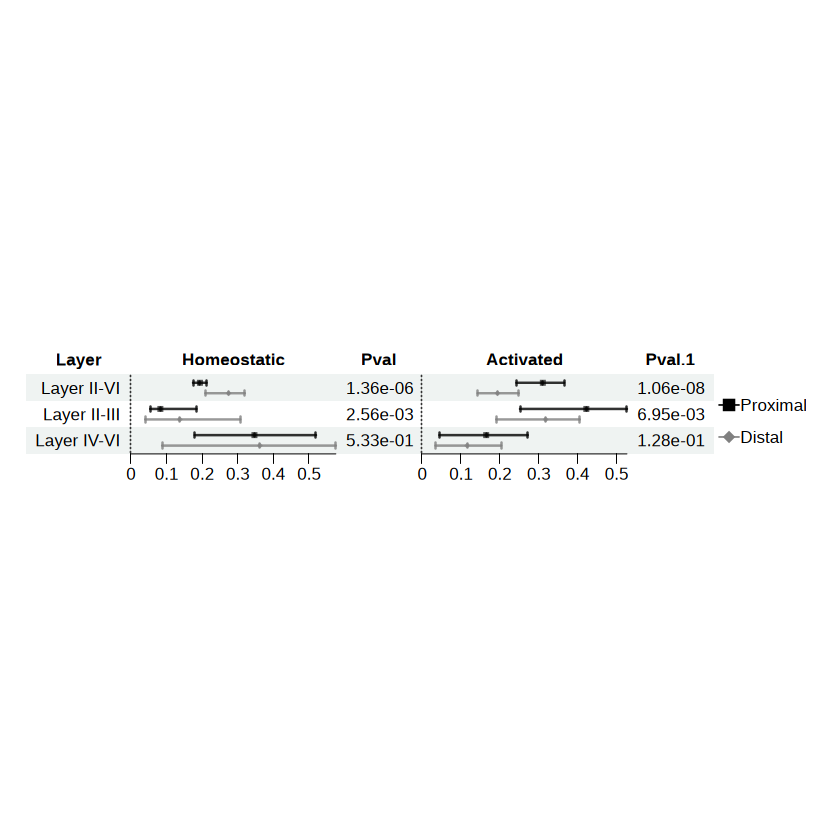

In [135]:
p <- forest(dt[,c(1,7,8,21,22)],
est = list(dt$Homeo_Level0_med,dt$Act_Level0_med,dt$Homeo_Other_med,dt$Act_Other_med),
lower = list(dt$Homeo_Level0_min,dt$Act_Level0_min,dt$Homeo_Other_min,dt$Act_Other_min),
upper = list(dt$Homeo_Level0_max,dt$Act_Level0_max,dt$Homeo_Other_max,dt$Act_Other_max),
            ci_column = c(2, 4),
            nudge_y = 0.4,
            theme = tm)
ggsave(p,filename = "Ab_Forestplot_inlayer.pdf",height = 4, width = 8)
p